In [96]:
using ValueShapes
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Statistics
using Distributions 
using IntervalSets
using BAT

using HCubature
using JLD2
using CPUTime
using LaTeXStrings
using SpecialFunctions
using KernelDensity

# using Plots
# using Colors
# using ColorSchemes
# pyplot(size=(750,500))
# line_colors = ColorSchemes.tab20b;

In [2]:
using PyPlot

In [3]:
using BATPar
using KDTree
include("plotting recipes.jl")

corner_plots (generic function with 4 methods)

# Generate Distribution: 

In [ ]:
# data = hcat(randn(1000), randn(1000))

# sx, sy = 0.12, 0.15

# Scale = [sx 0; 0 sy]

# theta = 0.75*pi

# c, s = cos(theta), sin(theta)

# Rot = [c -s; s c]

# T = Scale * Rot

# data_p =(data * T)';

# sigma = cov(data_p')

# @show sigma

In [ ]:
# Correlated Normal:

sigma_1 = [0.32716446841097613 0.17276467616026275; 0.17276467616026275 0.33056237691918017]
sigma_2 = [0.15152028283087893 -0.11598742336072133; -0.11598742336072133 0.1616797732933265] #[0.1572026439007445 -0.1044956058704804; -0.1044956058704804 0.13445945463874312] 
sigma_3 = [0.01942201849281335 -0.003187584896683795; -0.003187584896683795 0.017175237584791444]

N = 2 
min_v = -50
max_v = 50
lgV = N*log(max_v-min_v); 

g(x;μ=[0, 0], sigma=sigma) = pdf(MvNormal(μ, sigma), x)

f(x) = g(x, μ=[5, 5], sigma=sigma_1) + g(x, μ=[-5, -5], sigma=sigma_1) + 0.1*g(x, μ=[5, -5], sigma=sigma_3) + 0.9*g(x, μ=[-5, 5], sigma=sigma_2)

In [ ]:
# Normal Distribution

true_param =(μ1=0, μ2=-1, σ=1)
min_v = -8
max_v = 8
N = 4
lgV = N*log(max_v-min_v); 


function f(x::AbstractArray; true_param=true_param)
    tmp = prod(pdf.(Normal(true_param.μ1, true_param.σ), x))
    return tmp
end

In [ ]:
#Report distribution

sigma_1 = [0.32716446841097613 0.17276467616026275; 0.17276467616026275 0.33056237691918017]
sigma_3 = [0.01942201849281335 -0.003187584896683795; -0.003187584896683795 0.017175237584791444]

N = 2 
min_v = -20
max_v = 20
lgV = N*log(max_v-min_v); 

g(x;μ=[0, 0], sigma=sigma_1) = pdf(MvNormal(μ, sigma), x)

f(x) = (1/2.08)*(g(x, μ=[3.5, 3.5], sigma=sigma_1) + g(x, μ=[-3.5, -3.5], sigma=sigma_1) + 0.04*g(x, μ=[3.5, -3.5], sigma=sigma_3) + 0.04*g(x, μ=[-3.5, 3.5], sigma=sigma_3))

## Plot Distribution: 

In [ ]:
x_range = range(-10, stop=10, length=200)
y_range = range(-10, stop=10, length=200)

z = [f([i,j]) for i in x_range, j in y_range]';

levels_quantiles = [0.6, 0.96, 0.98, 0.999, 1,]
levels=quantile([z...], levels_quantiles)

@show levels

contour(x_range, y_range, z; fill=true, levels=levels, fillalpha=0.2, color=:blues)

# Generate MCMC Samples: 

In [ ]:
algorithm = MetropolisHastings()

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.35,
    β = 1.1,
    c = 1e-4..1e2
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 8..128,
    max_nsamples_init = 50,
    max_nsteps_init = 50,
    max_time_init = 18
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 10,
    max_nsteps_per_cycle = 100,
    max_time_per_cycle = 25,
    max_ncycles = 1
)

HMI_Manual_Settings = BAT.HMISettings(BAT.cholesky_partial_whitening!, 
        1000, 
        1.5, 
        0.1, 
        true, 
        16, 
        true, 
        Dict("cov. weighted result" => BAT.hm_combineresults_covweighted!)
    )

log_likelihood = params -> LogDVal((log(f(params.a))))

prior = NamedTupleDist(a = [[min_v .. max_v for i in 1:N]...],)

posterior = PosteriorDensity(log_likelihood, prior);

In [ ]:
nchains = 2
nsamples = 1*10^5
max_time = 150
max_nsteps = 10 * nsamples;

In [ ]:
samples, stats = bat_sample(posterior, (nsamples, nchains), MetropolisHastings(), tuning=tuning, init=init, burnin=burnin);

In [ ]:
hmi_data = BAT.HMIData(unshaped.(samples))
ahmi_ex_time = @CPUelapsed BAT.hm_integrate!(hmi_data)

ahmi_integral_run =[hmi_data.integralestimates["cov. weighted result"].final.estimate, hmi_data.integralestimates["cov. weighted result"].final.uncertainty]
log_smpl_int = log.(ahmi_integral_run) .+ lgV

In [ ]:
integral = exp.(log_smpl_int)

In [ ]:
plot(samples, (1,2), legend=true,)

# Distribution #2 

In [81]:
"""
    randcormatrix(d, η)
Generate a d-by-d random correlation matrix using the
method described in:
    Lewandowski, Kurowicka, Joe
      "Generating random correlation matrices based on vines
        and extended onion method"
    Journal of Multivariate Analysis 100 (2009)
    doi:10.1016/j.jmva.2009.04.008
"""
function randcormatrix(d, η)
    β = η + (d - 2) / 2
    u = rand(Distributions.Beta(β, β))
    r₁₂ = 2 * u - 1
    r = [   1 r₁₂ ;
          r₁₂   1 ]
    # In published paper this index is n = 2:d-1. n is never mentioned
    # again, but a mysterious k is, so we'll thus use k. A similar approach
    # was taken here: http://stats.stackexchange.com/a/125017/58921
    for k in 2:d - 1
        β = β - 1 / 2
        y = rand(Distributions.Beta(k / 2, β))
        u = randn(k)
        u /= norm(u)
        w = sqrt(y) * u
        A = cholesky(r).L
        z = A * w
        r = [ r  z ;
              z' 1 ]
    end
    return r
end

"""
    randcovmatrix(d, η, σ)
Use randcormatrix with desired vector of standard deviations σ
for each term to generate a random covariance matrix.
"""
function randcovmatrix(d, η, σ)
    length(σ) != d && throw(DimensionMismatch("length(σ) doesn't match d"))
    r = randcormatrix(d, η)
    Σ = zeros(d, d)
    @inbounds for i in 1:d, j in 1:d
        Σ[i,j] = r[i,j] * σ[i] * σ[j]
    end
    return Σ
end

randcovmatrix

In [124]:
n_clusters = 5
n_dims = 6
low=-10
high=10
η = .4

means = rand(Uniform(low,high), n_clusters, n_dims)
sigma = rand(Uniform(1,(high-low)/2), n_dims)
cov_m = zeros(n_clusters, n_dims, n_dims)

for i in 1:size(cov_m)[1]
#     cov_m[i,:,:] .= randcovmatrix(n_dims, η, sigma)
    η = rand(Uniform(0.1,0.5), 1)[1]
    cov_m[i,:,:] .= randcovmatrix(n_dims, η, sigma)
end

In [131]:
# JLD2.@save "MixtureModels/mixture-1.jld" means cov_m n_clusters

In [126]:
model = MixtureModel(MvNormal[MvNormal(means[i,:], Matrix(Hermitian(cov_m[i,:,:])) ) for i in 1:n_clusters])

# samples = rand(model, 10^6)
# counts,ybins,xbins,image = plt.hist2d(samples[1,:], samples[2,:], bins=80);
# plt.contourf(counts',extent=[minimum(xbins),maximum(xbins),minimum(ybins),maximum(ybins)],linewidths=1)

In [127]:
iid_distributions = NamedTupleDist(a = model,)

samples_iid = bat_sample(iid_distributions, 10^6).result; 

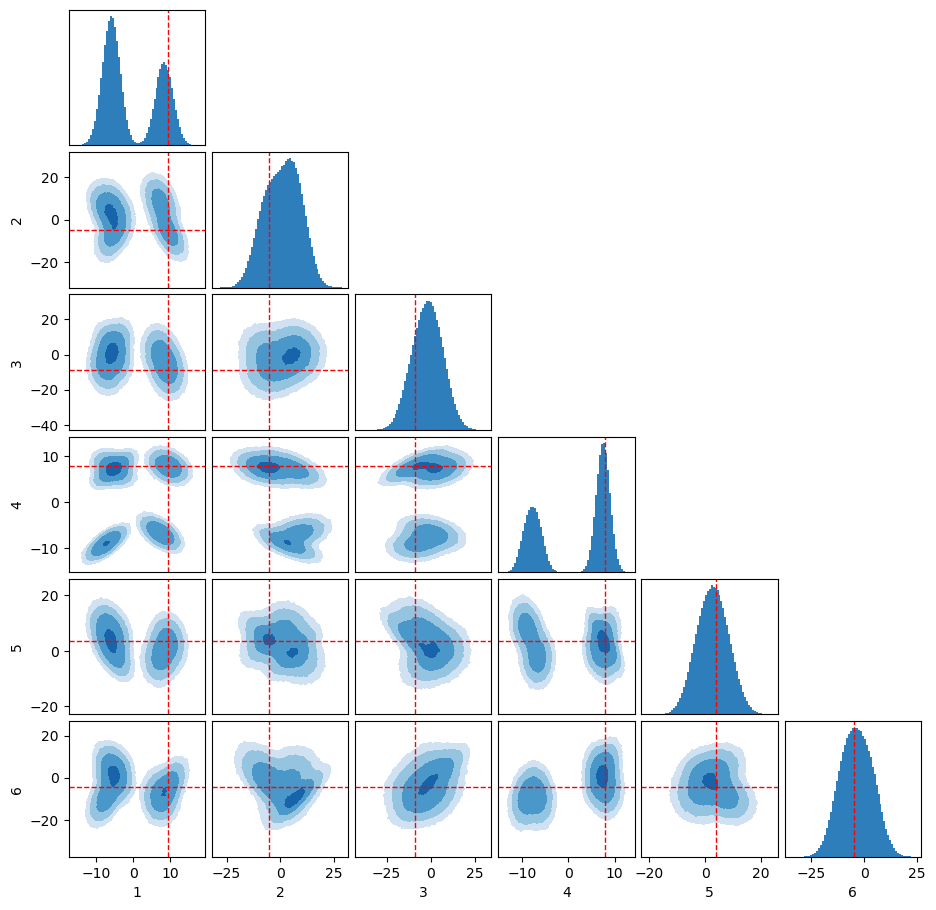

In [128]:
corner_plots(samples_iid, [1,2,3,4,5,6], ["1", "2", "3", "4", "5","6"], N_bins=70, save_plot=false) #levels_quantiles = [ 0.7, 0.9, 0.99, 1,],


In [129]:
# corner_plots(samples_iid, [6,7,8,9,10], ["6", "7", "8", "9", "10"], N_bins=70, save_plot=false) #levels_quantiles = [ 0.7, 0.9, 0.99, 1,],


In [123]:
B = kde(collect(flatview(unshaped.(samples_iid.v)))[1:2,:]')

BivariateKDE{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}(-47.93593696067998:0.3976788467293681:53.47216895530889, -41.640066214141505:0.30736048134119104:36.73685652786221, [3.324194199563603e-18 2.5126242865491053e-17 … 4.46414881644039e-17 5.4337840150021234e-18; 0.0 0.0 … 0.0 0.0; … ; 9.535128130795507e-18 1.8641763939686063e-17 … 5.127449412237225e-17 0.0; 0.0 0.0 … 0.0 0.0])